In [99]:
#Импортируем необходимые библиотеки для проекта
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
import numpy as np
import scipy.stats as ss
import pingouin as pg
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import pandas as pd 
import requests 
from urllib.parse import urlencode 
from scipy.stats import bootstrap
from scipy import stats


**1.Предварительный анализ данных**


In [5]:
#Используем api для подгрузки файлов
#Вводим ссылку на публичный ключ
groups_public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

#Создаем функцию для подгрузки датафрейма по ключу
def get_yandex_csv(public_key, sep):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep=sep)


,id,grp
0,1489,B
1,1627,A
2,1768,B


In [61]:
groups = get_yandex_csv(groups_public_key, ';') #Пользователь - принадлежность к группе
group_add = get_yandex_csv(groups_add_public_key, ',') #Доп файл по связи юзер-группа, спустя 2 дня после начала эксперимента
active_studs = get_yandex_csv(active_studs_public_key, ';') #Пользователи зашли на платформу в дни проведения эксперимента
checks = get_yandex_csv(checks_public_key, ';') #Оплата пользователей в дни проведения эксперимента


*Осуществим необходимые проверки датасэтов*

1.1. Проверим типы параметров в сэтах

In [40]:
groups.dtypes

id      int64
grp    object
dtype: object

In [41]:
group_add.dtypes

id,grp    object
dtype: object

In [42]:
active_studs.dtypes

student_id    int64
dtype: object

In [43]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

Типы параметров соответствуют ожидаемому поведению:
- Айдишники типа int, не стринга и не object
- Наименоание контрольной группы тип object, можно привести к строковому типу, если будет необходимо, но для строк нормальный тип данных
- Оплата в типе float, что соответствует оплате с учетом копеек или центов


Далее проверим пустые значения. В группах с пользователями нежелательно иметь незаполненные значения группы, т.к. таких юзеров придется "выбросить" из анализа, поскольку непонятно будет, к какой группе они относятся. Также желательно проверить, что в сведениях об оплате нет отрицательных чисел

In [44]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [45]:
group_add.isna().sum()

id,grp    0
dtype: int64

In [46]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [47]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [48]:
checks.query("rev <= 0")

,student_id,rev


In [49]:
#Дополнительно проверим дубли

In [50]:
groups.id.duplicated().sum() 
#Проверим именно айди студента, т.к. если имеются две и более записи по 1 студенту, это повод задуматься

0

In [56]:
active_studs.duplicated().sum()

0

In [60]:
group_add

,"id,grp"
0,"5694584,B"
1,"5694830,B"
2,"5695057,B"
3,"5698872,B"
4,"5699067,B"
...,...
87,"200247820,B"
88,"201032527,B"
89,"201067612,B"
90,"201067653,B"


In [62]:
group_add.id.duplicated().sum() #Аналогично, как и в groups

0

In [58]:
checks.student_id.duplicated().sum() #Чисто в теории 1 пользователь мог бы сделать несколько оплат в день

0

Проверим на наличие противоречивых данных в датасетах. Например, есть ли у нас пользователи, которые оплатили, но не являются активными или нет ли такого, что пользователь у нас отнесен к двум группам одновременно.

In [59]:
groups.id.nunique() - groups.count()

id     0
grp    0
dtype: int64

Как видим, у нас количество уникальных записей совпадает с количеством строчек.

In [38]:
#Проверим на наличие неактивных и оплативших юзеров
#Воспользуемся inner-обхединением, чтобы понять, какие студенты
# у нас не оплатили
df_cheking=checks.merge(active_studs,how='inner', on='student_id')
df_cheking

,student_id,rev
0,1627,990.0000
1,100300,990.0000
2,108270,290.0000
3,264473,1900.0001
4,274352,690.0000
...,...,...
387,5645737,1900.0000
388,5651566,1900.0000
389,5662322,1900.0000
390,5681918,1900.0000


In [39]:
541-392

149

Видим, что в изначальном списке оплативших у нас 541 человек, а при объединении отвалилось 149 юзеров, которые неактивные, но оплатили. Их можно не учитывать далее ( *они далее не учитывались, когд мы отобрали только активных пользователей, у которых оплата больше 0* ).

Как мы видим, пропущенных значений нет ни в одном датасете. Более того, нет отрицательных оплат. По предварительной проверке можно сделать вывод, что данные готовы к дальнейшему анализу

# Задание 1

**2. ВОПРОСЫ**

2.1 На какие метрики вы смотрите в ходе анализа и почему?

2.2 Имеются ли различия в показателях и с чем они могут быть связаны?

2.3 Являются ли эти различия статистически значимыми?

2.4 Стоит ли запускать новую механику на всех пользователей?


2.1 Поскольку эксперимент подразумевает собой выявление наиболее прибыльного способа оплаты, то можно рассмотреть следующие метрики:

- Проверить, вырос ли средний чек по оплате. Возможно, что из-за удобства новой системы пользователи стали приобретать больше товаров или услуг
- Проверить волатильность медианного чека

Ведь если разница между  среднимим чеками пользователей  групп имеется, то можно сделать определенные выводы об успешности новой механики оплаты. Например, если  в группе А(контроль) средний чек  пользователя оказался значимо ниже, чем в группе В ( целевой), то можно выдвинуть утверждение об успешности новой механики оплаты.

Видвигать предположение о соотношении активных и неактивных юзеров здесь не получится, поскольку в условии взяты рандомные дни и пользователи не знали об изменении. Да и целевых действий по отмене тоже не было.

Чтобы ответить на вопросы 2.2-2.4, необходимо проанализировать данные и рассчитать метрики: средний чек юзера.

*Выдвинем гипотезы*

**H0**: Средний чек пользователя контрольной группы А значимо не отличается от среднего чека целевой группы В

Поскольку работа с файлом groups_add предусматривается в 3 задании, для начала проверим наши гипотезы, рассчитав метрики на имеющихся данных так, как будто у нас еще нет данных о пользователях, пришедших спустя два дня. 

In [63]:
#Для удобства мерджа переименуем столбец 
active_studs=active_studs.rename(columns={'student_id':'id'})
active_studs

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [64]:
#Объединим три датафрейма - groups,active_studs,checks, 
#Чтобы получить полную информацию о том, какие пользователи участвовали в эксперименте и информацию об сумме их оплат
#Это сразу позволит отсеить неактивных пользователей, которые не были на платформе в день эксперимента, но совершили оплату
active_grouped_users=active_studs.merge(groups, how='left', on='id')
active_grouped_users

,id,grp
0,581585,A
1,5723133,NaN
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


Проверим, есть ли у нас в выборе пользователи с незаполненной группой, поскольку в файле с активными пользователями могли оказаться те, которые не попали ни в какую группу или из 2го файла


In [65]:
active_grouped_users.isna().sum()
#У нас есть 13 пользователей без группы. 
#На данный момент их лучше исключить из выборки, поскольку мы не знаем,к какой группе они относятся

id      0
grp    13
dtype: int64

In [66]:
active_grouped_users=active_grouped_users.dropna()
active_grouped_users

,id,grp
0,581585,A
2,3276743,B
3,4238589,A
4,4475369,B
5,5481015,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


Далее подгрузим данные об оплате по каждому пользователю. Пустоту можно заполнить 0, если не было оплаты. Заполняем 0, поскольку нам нужно понимать успешность нового механизма.


In [67]:
#Для удобства мерджа переименуем столбец 
checks=checks.rename(columns={'student_id':'id'})
active_grouped_users2=active_grouped_users.merge(checks,how='left', on='id')
active_grouped_users2['rev']=active_grouped_users2['rev'].fillna(0) 
active_grouped_users2

,id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0
...,...,...,...
8323,1794344,B,0.0
8324,296883,B,0.0
8325,3598448,B,0.0
8326,3610547,B,290.0


Наши данные готовы. Теперь можно разбить по группам контрольная А и целевая Б.

In [68]:
contr_A=active_grouped_users2.query("grp == 'A'")[['id','rev']]
test_B=active_grouped_users2.query("grp == 'B'")[['id','rev']]

In [69]:
contr_A.shape

(1535, 2)

In [70]:
test_B.shape

(6793, 2)

Мы видим достаточно колоссальное отличие в количестве активных участников между контрольной и целевой группой. Результаты могут быть неожиданными.

In [71]:
contr_A_1=groups.query("grp == 'A'")
test_B_1=groups.query("grp == 'B'")

In [72]:
contr_A_1.shape

(14671, 2)

In [73]:
test_B_1.shape

(59813, 2)

Но и изначально мы видим, что их количество какое-то неравное 14,6 тыс против почти 60 тыс...
Отсюда можем вывести еще третью метрику: 
Соотношение количества пользователей, которые не произвели оплату. Их соотношение может оказаться одинаковым.

**H0**: Соотношение количества пользователей,  произведших оплату, в контрольной группе А значимо не отличется от аналогичного в целевой группе В.

## Гипотеза 1: Изменился ли средний чек 

### 1. Посмотрим на графики распределений ###

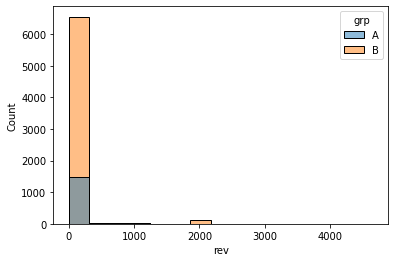

In [28]:
sns.histplot(data=active_grouped_users2, x="rev", hue="grp")

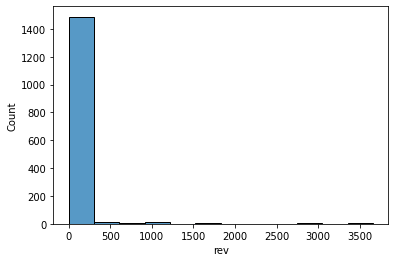

In [29]:
sns.histplot(data=contr_A, x="rev")

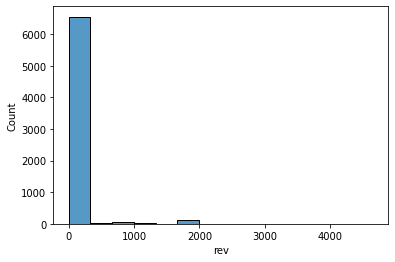

In [30]:
sns.histplot(data=test_B, x="rev")

По общей и точечной гистограмме мы видим превалирующее количество пользователей совершивших 0 покупок в обеих группах. Распределение не видится нормальным. Но, т.к. у нас большое число наблюдений ( больше 30), можем для сравнения средних использовать t-статистику.

### 2. Проверим распределения на нормальность

In [31]:
contr_A.describe()

,id,rev
count,1.535000e+03,1535.000000
mean,2.448344e+06,47.439739
std,1.584452e+06,290.766992
min,1.627000e+03,0.000000
25%,1.116413e+06,0.000000
50%,2.070805e+06,0.000000
75%,3.725562e+06,0.000000
max,5.690284e+06,3660.000000


In [32]:
test_B.describe()

,id,rev
count,6.793000e+03,6793.000000
mean,2.442220e+06,57.864567
std,1.555338e+06,313.197487
min,2.085000e+03,0.000000
25%,1.118614e+06,0.000000
50%,2.088960e+06,0.000000
75%,3.611806e+06,0.000000
max,5.689627e+06,4650.000000


Видимо, что среднее значение отличается, как и стандартное отклонение.

In [92]:
# Стат тест проверки на нормальность
pg.normality(data=active_grouped_users2, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,2235.003893,0.0,False
B,7799.583992,0.0,False


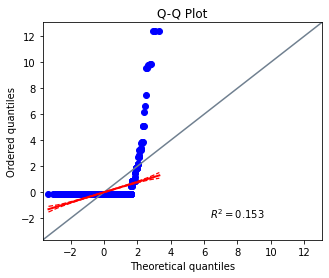

In [38]:
# Посмотрим на qq-plots
pg.qqplot(active_grouped_users2.query("grp == 'A'").rev)

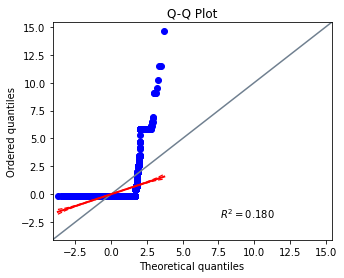

In [39]:
pg.qqplot(active_grouped_users2.query("grp == 'B'").rev)

Т.к. значения какие-то экстремальные, попробуем их сгладить при помощи логарифма, чтобы получить более наглядные графики

In [40]:
active_grouped_users2

,id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0
...,...,...,...
8323,1794344,B,0.0
8324,296883,B,0.0
8325,3598448,B,0.0
8326,3610547,B,290.0


In [41]:
#Логарифмирем значения
log_gr=active_grouped_users2.copy()
log_gr

,id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0
...,...,...,...
8323,1794344,B,0.0
8324,296883,B,0.0
8325,3598448,B,0.0
8326,3610547,B,290.0


In [42]:
log_gr['rev']=log_gr['rev'].apply(lambda x: np.log(x) if x>0 else x)
log_gr

,id,grp,rev
0,581585,A,0.000000
1,3276743,B,0.000000
2,4238589,A,0.000000
3,4475369,B,0.000000
4,5481015,B,0.000000
...,...,...,...
8323,1794344,B,0.000000
8324,296883,B,0.000000
8325,3598448,B,0.000000
8326,3610547,B,5.669881


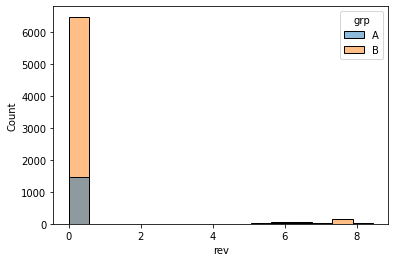

In [43]:
sns.histplot(data=log_gr, x="rev", hue="grp")

Особо ничего не изменилось с логарифимированием. Посмотрим qq-plots.

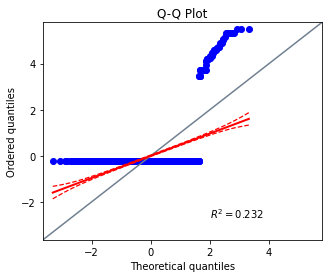

In [44]:
pg.qqplot(log_gr.query("grp == 'A'").rev)

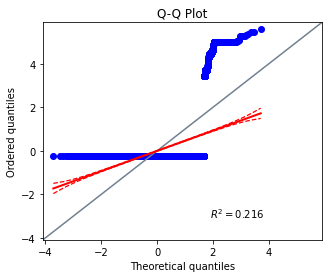

In [45]:
pg.qqplot(log_gr.query("grp == 'B'").rev)

Результаты в целом не лучше. Более того, дают полную картину того, что распределения отнюдь не нормальные. Однако нас интересует именно разница среднего чека. Далее можно провести два теста проверки гипотез: по неотфильтрованным данным с учетом пользователей, совершивших покупку, и отфильтрованным, совершивших покупку. Ведь нас интересует именно результат целевого действия, который может потеряться -- покупка

In [75]:
active_grouped_users2

,id,grp,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0
...,...,...,...
8323,1794344,B,0.0
8324,296883,B,0.0
8325,3598448,B,0.0
8326,3610547,B,290.0


In [76]:
#Предварительные проверки
active_grouped_filtered=active_grouped_users2.query("rev>0")
active_grouped_filtered.groupby("grp",as_index=False).agg({'id':'count'})

,grp,id
0,A,78
1,B,313


In [77]:
active_grouped_filtered

,id,grp,rev
61,1184303,A,1530.0000
66,3354191,B,1900.0001
76,3278734,B,1900.0000
98,720651,A,1980.0000
191,1232221,B,1900.0000
...,...,...,...
8188,3890326,B,199.0000
8191,1390994,A,398.0000
8250,1516339,A,290.0000
8264,3910596,B,597.0000


In [49]:
A=active_grouped_filtered.query("grp == 'A'")
B=active_grouped_filtered.query("grp == 'B'")

In [50]:
A.describe()

,id,rev
count,7.800000e+01,78.000000
mean,2.924680e+06,933.589744
std,1.657487e+06,919.932711
min,1.627000e+03,199.000000
25%,1.403057e+06,290.000000
50%,3.176553e+06,585.000000
75%,4.345213e+06,1114.750000
max,5.577840e+06,3660.000000


In [51]:
B.describe()

,id,rev
count,3.130000e+02,313.000000
mean,2.820509e+06,1255.827487
std,1.604794e+06,791.293377
min,1.003000e+05,199.000000
25%,1.281916e+06,489.000000
50%,3.087954e+06,1140.000000
75%,4.161439e+06,1900.000000
max,5.681918e+06,4650.000000


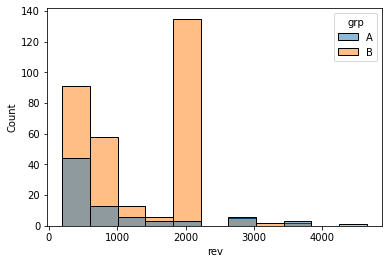

In [52]:
sns.histplot(data=active_grouped_filtered, x="rev", hue="grp")

Распределение немного скошенное, во всяком случае, для группы А, ассиметричное как будто.

In [53]:
pg.normality(data=active_grouped_filtered, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,30.37842,2.531687e-07,False
B,7.02227,2.986301e-02,False


In [54]:
pg.normality(data=active_grouped_filtered, dv="rev", group="grp")

,W,pval,normal
A,0.735324,1.498682e-10,False
B,0.855199,1.756779e-16,False


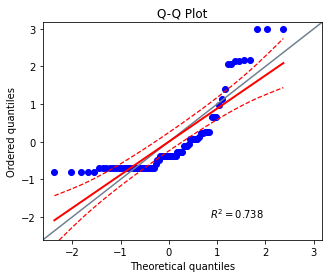

In [55]:
pg.qqplot(active_grouped_filtered.query("grp == 'A'").rev)

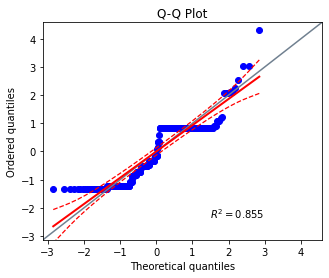

In [56]:
pg.qqplot(active_grouped_filtered.query("grp == 'B'").rev)

Итог проверки на нормальность:
Данные не являются нормально распределенными. Более того,в неотфильтрованных данных преобладает большое количество пользователей, не совершивших покупку вовсе. Из-за того, что нас интересует более целевой действие - покупка - будем рассматривать гипотезы относительно отфильтрованного списка.

### 3. Сравнение средней суммы покупок пользователя

Т.к. данные не являются нормально распределенными, можно использовать непараметрические тесты, например, Манна-Уитни. Но при большом объеме выборки (большим 30) можно применять и t-тест, т.к. распределение будет стремиться к нормальному с большим степеней свободы.

In [94]:
#Проверим стандартное отклонение
active_grouped_filtered.groupby("grp").rev.std()

grp
A    919.932711
B    791.293377
Name: rev, dtype: float64

С помощью теста Левана определяем равенство дисперсий

**H0**: Дисперсии внутри групп равны
**H1**: Дисперсии внутри групп отличаются

In [60]:
ss.levene(active_grouped_filtered.query("grp == 'A'").rev, active_grouped_filtered.query("grp == 'B'").rev)

LeveneResult(statistic=3.055864350672603, pvalue=0.08123509393501775)

p-value  >0.05, а это значит, что отличий нет. Дисперсии одинаковы между группами А и В для обоих кейсов.

Ранее мы проводили распределение выборок на нормальность. Распределения оказались ненормальными. Можно использовать и т-тест, но в распределении есть выборсы, судя по графику. Если бы оно отдаленно напоминало нормальное, то можно было бы его применить и при провале тестов.
Применим далее бутстрап.

In [108]:
#bootstrap по отфилтированной группе А
#среднее 933.59
bootstrap((active_grouped_filtered.query("grp == 'A'").rev, ), np.mean,confidence_level= 0.995)

BootstrapResult(confidence_interval=ConfidenceInterval(low=688.7707154717377, high=1303.8668217585919), standard_error=104.24173770955866)

In [109]:
#bootstrap по отфилтированной группе В
#среднее 1255.83
bootstrap((active_grouped_filtered.query("grp == 'B'").rev, ), np.mean,confidence_level= 0.995)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1136.5827910342853, high=1385.0685750398484), standard_error=44.646022101441744)

Таким образом, мы видим, что для **отфильтрованной** выборки все в точности да наоборот: p-value <0.05 (0.005). Это значит,*грубо говоря*, что  мы можем получить совпадения по среднему чеку в менее 0.05% случаев. 
В отфильтрованном списке разница намного выше:
для А - среднее 933.59 с интервалом (686.21;1281.93) и для В - 1255.83 с интервалом (1136.82;1377.08). Разница  примерно в 300 рублей.

## Вывод по гипотизе 1:
Мы видим, что для группы В средний платеж (чек) оказался выше. А разница в чеках пользователей не одинаковая для двух групп. Однако, и количество пользователей в этой группе тоже больше,чем в А. И здесь можно проверить Гипотезу 2 по равенству медиан. Ибо медиана может отличаться от среднего при различных выбросах.

Значит, мы отвергаем **H0**, что у нас нет отличий в средних чека пользователя, но принимаем гипотезу о том, что дисперсии групп равны.

## Гипотеза 2: Какова разница в медианах

Т.к. мы уже сделали все предварительные шаги по проверке распределния на нормальность, можно воспользоваться бутстрапом по медиане.
**H0**: Медианы не отличаются

In [81]:
median_diff = []
old_revenue=active_grouped_filtered.query("grp == 'A'").rev
new_revenue=active_grouped_filtered.query("grp == 'B'").rev

for i in range(1000):
    sample_old = old_revenue.sample(frac=1, replace=True)
    sample_median_old = sample_old.median()
    
    
    sample_data_new = new_revenue.sample(frac=1, replace=True)
    sample_median_new = sample_data_new.median()
    
    sample_median_diff = sample_median_new - sample_median_old 
    median_diff.append(sample_median_diff)

In [82]:
high=pd.Series(median_diff).quantile(0.975)
low=pd.Series(median_diff).quantile(0.25)
low,high

(500.0, 1320.0)

In [83]:
old_revenue.median()

585.0

In [84]:
new_revenue.median()

1140.0

In [85]:
#Расчет при помощи пингвина
pg.compute_bootci(active_grouped_filtered.query("grp == 'B'")["rev"], 
                  active_grouped_filtered.query("grp == 'A'")["rev"], 
                  func=lambda x, y: np.median(x) - np.median(y),confidence=0.975, n_boot=1000)

array([ 150., 1320.])

Также видим разницу в медианах между группой А и В: 585 против 1140, находящаяся в диапазоне (460.0, 1320.0). Как мы видим, 0 находится довольно далеко за пределами доверительного интервала, а значит, и гипотезу 2 мы отклоняем в пользу альтернативной: медианы отличаются.

## Гипотеза 3: Соотношение количества пользователей,  произведших оплату, не изменилось


In [87]:
active_grouped_users2['is_payed']=active_grouped_users2['rev'].apply(lambda x: 1 if x>0 else 0)
active_grouped_users2

,id,grp,rev,is_payed
0,581585,A,0.0,0
1,3276743,B,0.0,0
2,4238589,A,0.0,0
3,4475369,B,0.0,0
4,5481015,B,0.0,0
...,...,...,...,...
8323,1794344,B,0.0,0
8324,296883,B,0.0,0
8325,3598448,B,0.0,0
8326,3610547,B,290.0,1


In [88]:
#Выведем соотношение признаков в каждой из групп
pd.crosstab(active_grouped_users2.grp, active_grouped_users2.is_payed)

is_payed,0,1
grp,,
A,1457,78
B,6480,313


In [89]:
#Проверим тестом хи-квадрат
exp, obs, stats = pg.chi2_independence(data=active_grouped_users2, 
                                       x="grp", 
                                       y="is_payed")
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.526607,1.0,0.468037,0.007952,0.112168
1,cressie-read,0.666667,0.523446,1.0,0.469375,0.007928,0.111786
2,log-likelihood,0.000000,0.517247,1.0,0.472019,0.007881,0.111037
3,freeman-tukey,-0.500000,0.512702,1.0,0.473971,0.007846,0.110488
4,mod-log-likelihood,-1.000000,0.508246,1.0,0.475899,0.007812,0.109950
5,neyman,-2.000000,0.499590,1.0,0.479680,0.007745,0.108905


In [90]:
#Соотношение оплативших ко всем в группе А
78/(1457+78)

0.050814332247557006

In [91]:
#Соотношение оплативших ко всем в группе В

313/(6480+313)

0.04607684380980421

Видим, что по всем тестам у нас соотношение оплативших не изменилось (p-value >0.05). Мы не можем отклонить нулевую гипотезу о равенстве соотношений. Они примерно одинаковые (0.05 оплативших в группе А и 0.04 - в группе В).

# Выводы:
Таким образом, для гипотезы отличия среднего чека в двух группах по отфильтрованым пользователям мы смогли отклонить нулевую гипотезу. А значит, средний чек увеличился. По гипотезе два - о различии медиан - тоже отклоняем нулевую гипотезу. Гипотеза 3 о наличии различий в соотношении оплативших пользователей ко всему количеству, не подтвердилась: нулевая гипотеза оказалась верна. Тем и лучше: у нас есть все доказательства того, что по соотношению пользователей ничего сильно не изменилось, но при этом вырос средний чек практически на 300 рублей, а медианный чек меняется в интервале (460;1320).

В целом новая механика оплаты показала себя достойно. Можно ее запускать, учитывая следующее:

- Нет времени на долгие эксперименты ( можно было бы понаблюдать в течение месяца или хотя бы двух недель и собрать более точную выборку с примерно одинаковым соотношением лиц в группах А и В)
- Разница в 300 рублей нас устраивает. Ведь если ожидался минимальный детектируемый эффект, например, в 2000 рублей или больше, то результаты эксперимента не валидны в таком случае 

# Задача 3

Поскольку задача 3 связана с первой,  перейдем к выполнению данного пункта

**Вопросы**

1.Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2.Реализуйте функцию, которая будет строить графики по получаемым метрикам.

## Функция подгрузки доп данных и пересчет метрик

У нас есть три метрики:

- Средний чек по оплате
- Соотношение количества оплативших ко всем
- Средний медианный чек

Перед тем, как сделать анализ, узнаем, сколько там вообще пользователей, которые:

- Являются активными
- Совершили оплату
- Определены в группу

Поскольку до этого не включили их в основной алгоритм из-за того,что про них говорится в 3м задании. Заодно можно попробовать определить эффект на метрики

In [83]:
group_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


Всего 92 пользователя в доп файле

In [85]:
tsk3=group_add.merge(active_studs, how='inner', on='id')
tsk3
    

,id,grp
0,5700613,B
1,5723133,A
2,5723648,B
3,5728431,B
4,5729371,A
5,5730382,B
6,5739944,B
7,5740903,B
8,5760471,B
9,5777081,B


Видим, что из 92 пользователей только 12 являются активными. Проверим, сколько из них оплачивали вообще.


In [86]:
checks

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [87]:
tsk3_1=tsk3.merge(checks, how='left', on='id')
tsk3_1

,id,grp,rev
0,5700613,B,NaN
1,5723133,A,NaN
2,5723648,B,NaN
3,5728431,B,NaN
4,5729371,A,NaN
5,5730382,B,NaN
6,5739944,B,NaN
7,5740903,B,1900.0
8,5760471,B,NaN
9,5777081,B,NaN


Как мы видим, только 1 человек внес оплату. Это существенно никак не повлияет на метрики

In [2]:
#Подгрузим дополнительные либы для работы с чтением файлов
import pandas as pd 
import requests 
from urllib.parse import urlencode 
 


In [379]:
def add_info (metric_name):
   #Используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
 
    #получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
 
    #Загружаем файл в df 
    download_response = requests.get(download_url) 
    group_add_tsk_3 = pd.read_csv(download_url, sep=',')
    #Объединяем с нашим основным файлом group
    all_data_gr=groups.merge(group_add, how='outer',on=['id','grp'])
    #Отделяем активных и оплативших юзеров. Ранее в задании мы переименовывали названия для удобства мерджа в задании 1
    all_active_usrs=active_studs.merge(all_data_gr, how='left', on='id')
    paid_usrs=all_active_usrs.merge(checks,how='left', on='id')
    paid_usrs['rev']=paid_usrs['rev'].fillna(0) 
    paid_usrs_2=paid_usrs.query("rev >0")
    #Разделим пользователей на группы
    #Считаем метрики
    #Средний чек
    AOV = paid_usrs_2.groupby('grp', as_index=False)\
        .agg({'rev': 'mean'})\
        .rename(columns={'rev': 'AOV'})\
        .round(3)\
        .rename(columns={'grp':'group_AOV'})
    #Соотношение оплативших пользователей ко всем
    paid_usrs['is_payed']=paid_usrs['rev'].apply(lambda x: 1 if x>0 else 0)
    cross_tbl=pd.crosstab(active_grouped_users2.grp, active_grouped_users2.is_payed)
    df_cr=pd.DataFrame(data=cross_tbl, index=['A', 'B'],columns=[0,1] )
    df_cr['Total']=df_cr[0]+df_cr[1]
    df_cr['CR']=round(df_cr[1]/df_cr['Total'],2)
    CR=pd.DataFrame(df_cr['CR'],index=['A','B'])
    CR=CR.reset_index().rename(columns={'index':'group_CR'})
    #Медиана
    Median = paid_usrs_2.groupby('grp', as_index=False)\
        .agg({'rev': 'median'})\
        .rename(columns={'rev': 'Median'})\
        .round(3)\
        .rename(columns={'grp':'group_Median'})
    if metric_name=='AOV': #если передана метрика среднего чека
        res=AOV
        return res
    elif metric_name == 'CR': #если передана метрика соотношения
        res=CR
        return res
    elif metric_name =='Median': #если передана метрика Медиана
        return Median
    else: #во всех других случая выводим все
        z = pd.concat([AOV, CR, Median], axis=1,sort=False)
        res=pd.DataFrame(data=z[['group_AOV','AOV','CR','Median']]).rename(columns={'group_AOV':'group'})
        return res   

In [386]:
df_tsk_3_1=add_info(metric_name='')
df_tsk_3_1
#Как мы видим, вызвав кейс по всем метрикам, они сильно не изменились по нашим предположениям,
#если мы считаем их по активным И оплатившим пользователям

,group,AOV,CR,Median
0,A,933.590,0.05,585.0
1,B,1257.879,0.05,1140.0


## Функция графиков метрик

In [387]:
def graphics (*args):
    if df_tsk_3_1.shape[1] >2:
        #Определяем расположение наших графиков. Все в 1 строки, поделенной на 3 столбца
        figure, ax = plt.subplots(1, 3, figsize=(12,5))
        #Добавляем наименование  графика общего
        figure.suptitle('Metrics', fontsize=19, fontweight='bold')
        #Определяем цвет наших барплотов
        color = ['red','blue']
        #Рисуем графики       
        graphic_AOV = sns.barplot(data=df_tsk_3_1, x='group', y='AOV', ax=ax[0], palette=color)
        graphic_Median = sns.barplot(data=df_tsk_3_1, x='group', y='Median', ax=ax[1], palette=color)
        graphic_CR = sns.barplot(data=df_tsk_3_1, x='group', y='CR', ax=ax[2], palette=color)
    else:
        #Определяем расположение наших графиков. Все в 1 строки, поделенной на 3 столбца
        figure, ax = plt.subplots(1, 1, figsize=(12,5))
        #Добавляем наименование  графика общего
        figure.suptitle('Metrics', fontsize=19, fontweight='bold')
        #Определяем цвет наших барплотов
        color = ['red','blue']
        graphic= sns.barplot(data=df_tsk_3_1, x=df_tsk_3_1.columns[0],y=df_tsk_3_1.columns[1], palette=color)

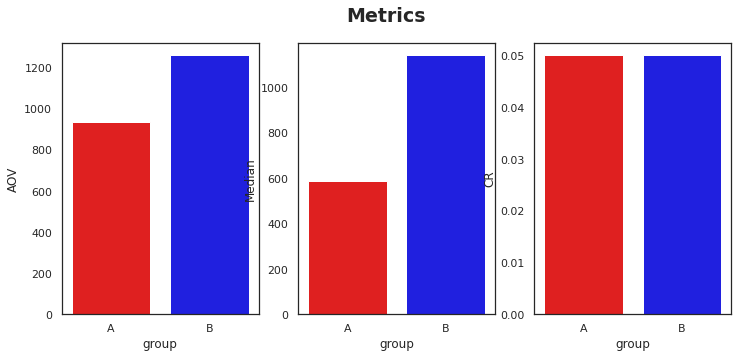

In [388]:
graphics()


# Задача 2

## задача 2.1
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [3]:
#Импортируем необходимые библиотеки для работы с clickhouse в jupiternotebooke
import pandahouse as ph

In [4]:
#Пропишем необходимы данные для соединения с clickhouse, которые мы использовали ранее в заданиях блока sql
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


In [8]:
#В нашем подзапросе считаем по каждому месяцу количество баллов у студентов и в основном запросе отбираем  тех,
#у кого от 20 и больше баллов за n-ый месяц m-го года
query = """
select count (st_id) as hard_working_students_amount from (
select st_id, formatDateTime(timest, '%G-%m') as month_year, count(correct) as total_score
from peas
where correct == 1
group by st_id, formatDateTime(timest, '%G-%m') as month_year
having sum(correct) >  19
order by total_score desc ) std_success
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,hard_working_students_amount
0,136


Отмечу, что при добавлении условие в where *and month_year like '2024-11'* выведет кол-во, равное  0

## задача 2.2
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

## У меня два варианта решения. Задание было самым сложным. Первый вариант - через cte делал. Но он громоздкий. 
## Второй-  покороче через специальные функции кликхауза, что нагуглил + cte
## Оба варианта совпали по ответам

**ВАРИАНТ1**

In [46]:
query2 = """
--
with grp_rev as (select test_grp, sum(fpc.money) as revenue
from default.final_project_check as fpc left join default.studs s on fpc.st_id=s.st_id
group by test_grp),

--
users_point_sum_inf as (select s.st_id as st_id,s.test_grp as test_grp , sum(p.correct) as total_points, sum(fpc.money) as revenue 
from 
default.studs as s left join default.peas as p on p.st_id=s.st_id
left join default.final_project_check as fpc on s.st_id=fpc.st_id
group by s.st_id,s.test_grp),
--
unique_users as (select test_grp, count (st_id) as users_amnt from users_point_sum_inf group by test_grp),
--
active_users as (select s.st_id as st_id, test_grp, sum(correct) as total_points  
from default.studs s left join default.peas p on s.st_id=p.st_id
group by s.st_id,test_grp having total_points>10),
--
active_users_mnt as (select test_grp, count(st_id) as users_amnt from active_users group by test_grp),
--
grp_rev_act as (select st_id, test_grp, sum(money) as revenue
from active_users a left join default.final_project_check as fpc on a.st_id= fpc.st_id
group by st_id,test_grp),
--
grp_rev_act_mnt as (select test_grp, sum(revenue) as revenue from grp_rev_act group by test_grp),
--
ARPU as (select a.test_grp as test_grp, round(revenue/users_amnt,2) as ARPU from grp_rev a inner join unique_users b on a.test_grp=b.test_grp),
--
ARPAU as (select a.test_grp as test_grp, round(revenue/users_amnt,2) as ARPAU from grp_rev_act_mnt  a inner join active_users_mnt b on a.test_grp=b.test_grp),
--
unique_paying_users as (select test_grp, count (distinct st_id) as paying_users_amnt from users_point_sum_inf group by test_grp having  revenue>0),
--
CR as (select a.test_grp as test_grp, round(a.paying_users_amnt/b.users_amnt,2) as CR_in_purch 
        from unique_paying_users a inner join unique_users b on a.test_grp=b.test_grp),
--
active_paying_users_mnt as (select test_grp, count(distinct st_id) as paying_users_amnt from grp_rev_act where revenue >0 group by test_grp),
--
CR_active as (select a.test_grp as test_grp , round(a.paying_users_amnt/b.users_amnt,2) as CR_active 
from active_paying_users_mnt a inner join active_users_mnt b on a.test_grp=b.test_grp),
--
math_students_info as (select s.st_id as st_id, test_grp, sum(correct) as correct 
from default.studs s left join default.peas p on s.st_id=p.st_id
where p.subject ilike 'math'
group by s.st_id,test_grp),
--
math_amnt as (select test_grp, count(distinct st_id) as users_amnt from math_students_info where correct >= 2 group by test_grp),
--
math_paying_info as (select m.st_id as st_id, test_grp, sum(money) as revenue 
from math_students_info m left join default.final_project_check fpc on m.st_id=fpc.st_id
where correct >=2  and subject ilike 'math'
group by m.st_id,test_grp
having revenue>0),
--
math_paying_mnt as (select test_grp, count(distinct st_id) as paying_users_amnt from math_paying_info group by test_grp),
--
CR_math as ( select msi.test_grp as test_grp, round(mpi.paying_users_amnt/msi.users_amnt,2) as CR_math 
from math_amnt msi inner join  math_paying_mnt mpi on msi.test_grp=mpi.test_grp)


select ARPU.test_grp, ARPU, ARPAU, CR_in_purch, CR_active,CR_math
from ARPU inner join ARPAU on ARPU.test_grp=ARPAU.test_grp
inner join CR on ARPU.test_grp=CR.test_grp
inner join CR_active on ARPU.test_grp=CR_active.test_grp
inner join CR_math on ARPU.test_grp=CR_math.test_grp
"""
df_2_1 = ph.read_clickhouse(query2, connection=connection_default)
df_2_1

,ARPU.test_grp,ARPU,ARPAU,CR_in_purch,CR_active,CR_math
0,control,4540.98,10393.70,0.05,0.11,0.06
1,pilot,11508.47,29739.58,0.11,0.26,0.10


**ВАРИАНТ 2**

In [47]:
query2_2="""
with all_scores_info as (
select st_id, sum(correct) as correct_all
from default.peas
group by st_id
having correct_all>0
order by correct_all),

math_score as (select st_id, sum(correct) as math_score
from default.peas
where subject ilike 'math'
group by st_id
--having math_score>=2
order by math_score),

total_info as (select s.st_id as st_id, fpc.money as revenue, test_grp,correct_all,math_score, subject
from default.studs s 
left join default.final_project_check as fpc on s.st_id=fpc.st_id
left join all_scores_info asi on s.st_id=asi.st_id
left join math_score ms  on s.st_id=ms.st_id)

select test_grp, 
round(sum(revenue)/count(distinct st_id),2) as ARPU,
round(sumIf(revenue,correct_all> 10)/countIf(distinct st_id, correct_all> 10),2) as ARPAU,
round(countIF(distinct st_id, revenue>0)/count(distinct st_id),2) as CR_in_purch,
round(countIf(distinct st_id, revenue>0  and correct_all> 10)/countIf(distinct st_id, correct_all> 10),2) as CR_active,
round(countIf(distinct st_id, revenue>0  and math_score>=2 and subject ilike 'math')/countIf(distinct st_id, math_score>=2),2) as CR_math
from total_info 
group by test_grp

"""
df_2_2 = ph.read_clickhouse(query2_2, connection=connection_default)
df_2_2

,test_grp,ARPU,ARPAU,CR_in_purch,CR_active,CR_math
0,control,4540.98,10393.70,0.05,0.11,0.06
1,pilot,11508.47,29739.58,0.11,0.26,0.10
